# EDA the Gaia DR3 Full Catalog

In [1]:
# generate edges 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

pd.options.display.max_rows = 200

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
from pyspark import SparkContext   
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

sc = spark.sparkContext
sqlsc = SQLContext(sc)
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

## Read the data 

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
filepath = \
"hdfs://spark00:54310/common/data/catalog/external-catalogs/parquet/gaia-dr3/raw/"

#### Read all parquets at once

In [6]:
%%time
# Read all parquets in the directory
rawdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(filepath)

CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 3.54 s


## EDA the full gaia catalog

In [7]:
#rawdf.printSchema()
#print(rawdf.columns)

In [8]:
df = rawdf.select('source_id','ra','dec','parallax','pm','pmra','pmdec', \
                  'astrometric_excess_noise','ruwe','classprob_dsc_combmod_quasar', \
                  'classprob_dsc_combmod_galaxy','classprob_dsc_combmod_star')

In [9]:
df.cache()

DataFrame[source_id: bigint, ra: double, dec: double, parallax: double, pm: float, pmra: double, pmdec: double, astrometric_excess_noise: float, ruwe: float, classprob_dsc_combmod_quasar: float, classprob_dsc_combmod_galaxy: float, classprob_dsc_combmod_star: float]

In [10]:
%%time
df.describe().toPandas().transpose()

CPU times: user 13.8 ms, sys: 4.92 ms, total: 18.7 ms
Wall time: 1min 43s


,0,1,2,3,4
summary,count,mean,stddev,min,max
source_id,1811709771,4.3515610592999291E18,1.64011514434601651E18,4295806720,6917528997577384320
ra,1811709771,229.12434364249648,77.78510767878045,3.4096239126626443E-7,359.999999939548
dec,1811709771,-18.3742705312265,36.53941026762332,-89.99287859590359,89.99005196682685
parallax,1467744818,0.36636113047677077,1.0261718025894784,-187.02939637423492,768.0665391873573
pm,1467744818,6.5300357767188295,6.208413714904138,1.9370936E-4,10393.349
pmra,1467744818,-2.5590960591401197,5.6427315902029305,-4406.469178827325,6765.995136250774
pmdec,1467744818,-3.1158782021276448,5.752189036045843,-5817.8001940492695,10362.394206546573
astrometric_excess_noise,1811709771,1.4472481372195902,5.413304658447028,0.0,1131.5846
ruwe,1467744818,1.0973414513193875,0.6082553477854727,0.19239865,116.016365


> 1.8 billion objects ! 

### Stellar Objects

In [11]:
%%time
stardf = df.filter((F.col('classprob_dsc_combmod_star') > 0.5) & (F.col('ruwe') < 1.4))

CPU times: user 361 µs, sys: 547 µs, total: 908 µs
Wall time: 11.2 ms


In [12]:
%%time
stardf.describe().toPandas().transpose()

CPU times: user 2.62 ms, sys: 3.96 ms, total: 6.58 ms
Wall time: 4.68 s


,0,1,2,3,4
summary,count,mean,stddev,min,max
source_id,1304979431,4.3132475589375631E18,1.72159960843960806E18,4295806720,6917528997577384320
ra,1304979431,224.7829530609693,81.18003284199813,3.4096239126626443E-7,359.999999939548
dec,1304979431,-16.595830099101676,38.30390216592703,-89.99287859590359,89.99005196682685
parallax,1304979431,0.37259322671276207,0.8913077253711856,-117.44857690096015,768.0665391873573
pm,1304979431,6.496989366913588,6.12618908576481,1.9370936E-4,10393.349
pmra,1304979431,-2.545775890181238,5.585905279504916,-4406.469178827325,6765.995136250774
pmdec,1304979431,-3.0701227486879583,5.7124510678202,-5817.8001940492695,10362.394206546573
astrometric_excess_noise,1304979431,0.5273923610173895,0.8399921220439863,0.0,17.405478
ruwe,1304979431,1.029485284339944,0.07270806560982891,0.20452607,1.4


> 1.3 billion stars ! 

#### Analyzing Parallax Values

In [13]:
%%time
n_negative_parallax = stardf.select('parallax').filter(F.col('parallax') < 0.0).count()
print(n_negative_parallax)

298359331
CPU times: user 1.57 ms, sys: 0 ns, total: 1.57 ms
Wall time: 1.26 s


> about these negative parallaxs, https://github.com/agabrown/astrometry-inference-tutorials/blob/master/luminosity-calibration/DemoNegativeParallax.ipynb

In [14]:
%%time
n_overone_parallax = stardf.select('parallax').filter(F.col('parallax') > 1.0).count()
print(n_overone_parallax)

180351811
CPU times: user 1.82 ms, sys: 0 ns, total: 1.82 ms
Wall time: 1.12 s


#### Remove extreme parallax

In [15]:
%%time
startrimdf = stardf.filter((F.col('parallax') < 1000.0) & (F.col('parallax') > 1.0e-5))

CPU times: user 556 µs, sys: 830 µs, total: 1.39 ms
Wall time: 5.22 ms


> What is the fiducial limit of parallax? 1e-6? 1e-8? 

In [16]:
%%time
startrimdf.select('parallax').count()

CPU times: user 600 µs, sys: 896 µs, total: 1.5 ms
Wall time: 1.11 s


1006612389

In [17]:
startrimdf.select('parallax').show(5)

+------------------+
|          parallax|
+------------------+
|0.3543305595550248|
| 3.235017271512856|
|3.1391701154499523|
| 1.383149618921834|
| 0.196147669341387|
+------------------+
only showing top 5 rows



#### Apply a short form of `lambda-udf `

In [18]:
import math

In [19]:
math.log10(10.0)

1.0

In [20]:
%time
getparsec = F.udf(lambda x: math.log10(1000.0/x), T.FloatType())
tmpdf = startrimdf.withColumn('logparsecs',getparsec(F.col('parallax')))

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.77 µs


In [21]:
tmpdf.select('parallax','logparsecs').show(3)

+------------------+----------+
|          parallax|logparsecs|
+------------------+----------+
|0.3543305595550248| 3.4505913|
| 3.235017271512856| 2.4901235|
|3.1391701154499523|  2.503185|
+------------------+----------+
only showing top 3 rows



In [22]:
math.log10(1.0/0.3543305595550248)

0.45059138993670944

In [23]:
%%time
bins, counts = tmpdf.select('logparsecs').rdd.flatMap(lambda x: x).histogram(500)

CPU times: user 437 ms, sys: 338 ms, total: 775 ms
Wall time: 1min 24s


In [24]:
len(bins)

501

In [25]:
len(counts)

500

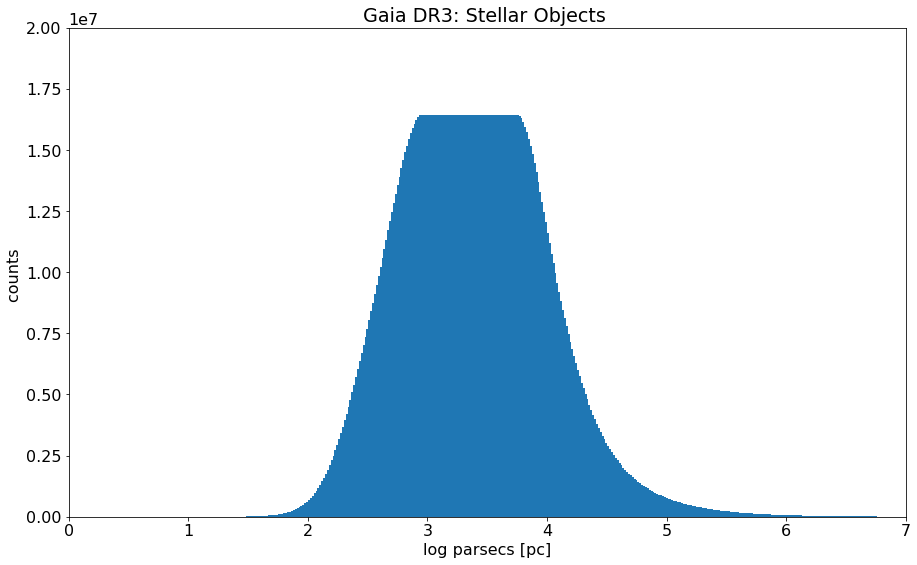

In [29]:
#bins, counts

#plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(15,9))

plt.axis([0,7,0,2.0e7])
#plt.axes().set_aspect('equal', 'datalim')
plt.title(r'Gaia DR3: Stellar Objects ')
plt.xlabel(r'log parsecs [pc]')
plt.ylabel(r'counts ')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(bins[1:],counts)

plt.show()


#### Group up stars based on healpix indices 

> healpy: https://healpy.readthedocs.io/en/latest/tutorial.html 

> which `nside`, which projection `mollview`(?) should be settled

In [27]:
np.log10(1.0/0.034)

1.4685210829577449